In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_list(lst):
    plt.figure()
    num_rows = len(lst)

    for i, word in enumerate(lst):
        plt.subplot(num_rows, 1, i+1)
        plt.imshow(word)
        
    plt.show()

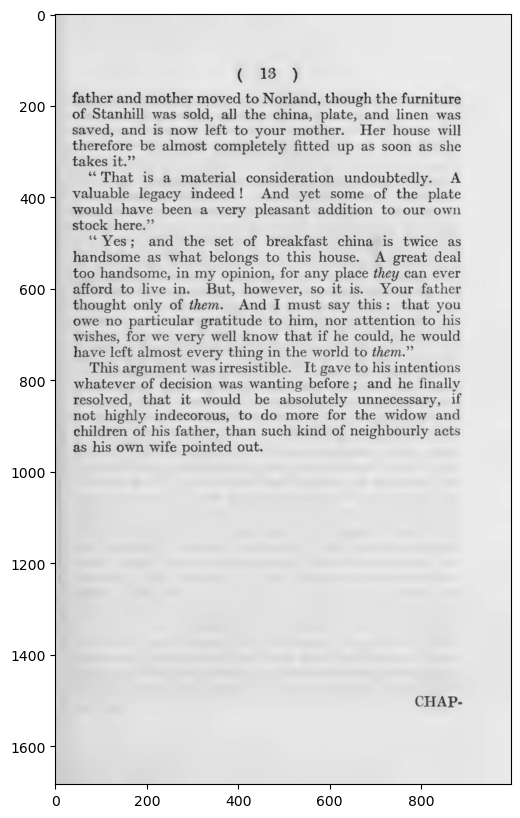

In [3]:
#imagepreview
plt.figure(figsize=(20,10))
img= cv2.imread('./test_from_dataset.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.show()

In [4]:
## LINE SEGMENTATION ##
def segment_lines(grayedImage, AREA_THRESHOLD=500, GAUSSIAN_BLUR_KERNEL=(3,5), DILATION_KERNEL_SIZE=(12,1), THRESH_NEIGHBORHOOD_SIZE=11, THRESH_TUNE=5):
    # AREA_THRESHOLD = 500
    # GAUSSIAN_BLUR_KERNEL = (3, 5) # (height, width) - odd numbers
    # DILATION_KERNEL_SIZE = (12, 1)  # (width, height) -TUNE THIS TO GET LINE GRANULARITY
    # THRESH_NEIGHBORHOOD_SIZE = 11
    # THRESH_TUNE = 5

    # Load image, grayscale, Gaussian blur, adaptive threshold
    # image = cv2.imread('./test_from_dataset.jpg')
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grayedImage, GAUSSIAN_BLUR_KERNEL, 0)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,THRESH_NEIGHBORHOOD_SIZE, THRESH_TUNE)

    # save an image to draw the lines and to extract lines from
    image_with_boxes = thresh.copy()
    image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    image_with_boxes = cv2.bitwise_not(image_with_boxes)
    clean_image = image_with_boxes.copy()

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (DILATION_KERNEL_SIZE)) # generates rectangular kernel of the given size
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    ROI_number = 0

    y_list = []
    lines = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area > AREA_THRESHOLD: # only draws boxes around blobs with a certain area
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (36,255,12), 1) # wtf do these args mean
            ROI = clean_image[y:y+h, x:x+w]
            y_list.append(y)
            lines.append(ROI)
            # cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
            # ROI_number += 1

    ordered_list = []
        
    y_list = np.asarray(y_list)
    for i in range(len(lines)):
        minYIndex = np.argmin(y_list)
        ordered_list.append(lines[minYIndex])
        y_list[minYIndex] = 10000
        
    return ordered_list, thresh, image_with_boxes


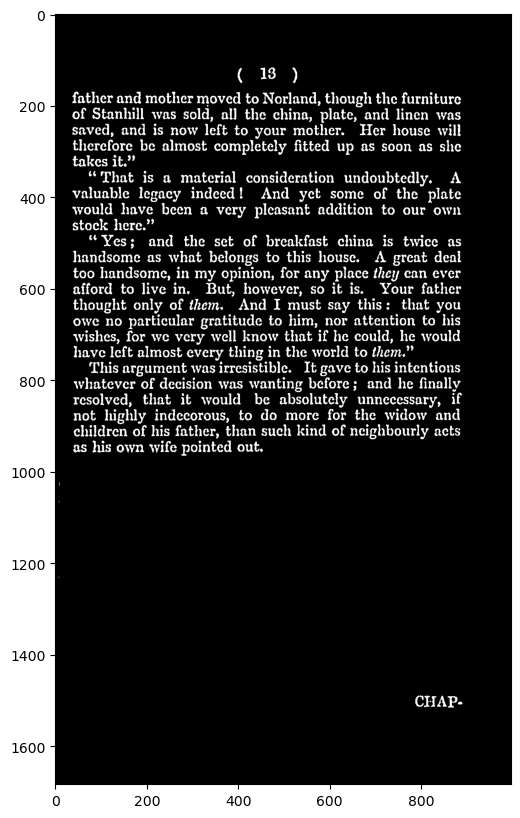

In [5]:
# preview intermediate images
lines, thresh, image_with_boxes = segment_lines(img)
plt.figure(figsize=(20,10))
plt.imshow(thresh, cmap='gray') # or thresh or dilate
plt.show()

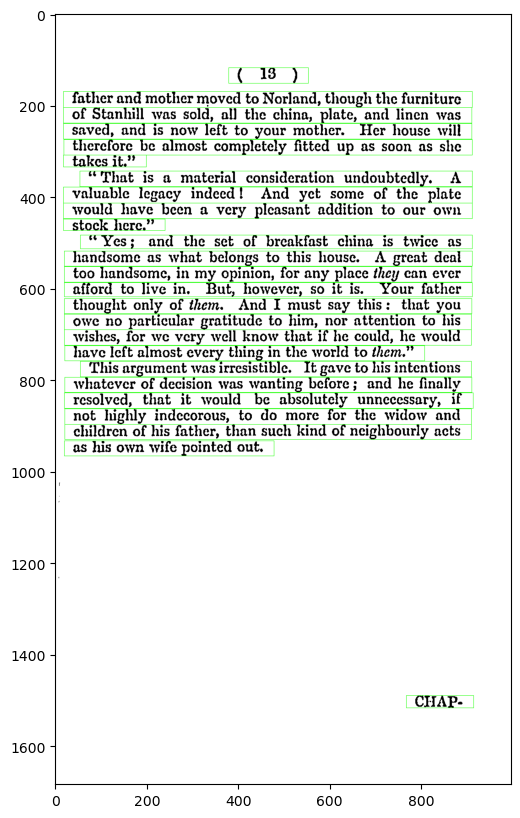

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(image_with_boxes)
plt.show()

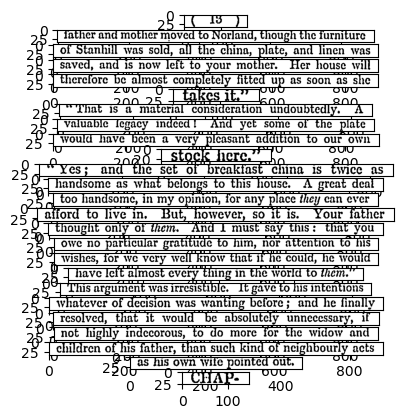

In [7]:
plot_list(lines)

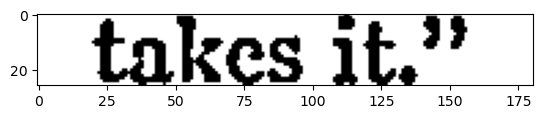

In [8]:
# single line preview
plt.imshow(lines[5])
plt.show()

In [ ]:
## WORD SEGMENTING ##
def segment_words(line, WORD_AREA_THRESHOLD=1, WORD_DILATION_KERNEL_SIZE=(5, 6)):
    # example_line = img_list[5] # an arbitrary example

    # WORD_AREA_THRESHOLD = 1
    # LINE_GAUSSIAN_BLUR_KERNEL = (3, 3) # (height, width) - odd numbers # don't blur it again
    # WORD_DILATION_KERNEL_SIZE = (5, 6)  # (width, height)

    image_with_boxes = line.copy()
    gray = cv2.cvtColor(line, cv2.COLOR_BGR2GRAY)

    # blur = cv2.GaussianBlur(gray, LINE_GAUSSIAN_BLUR_KERNEL, 0) # don't blur it again
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,50) # maybe don't need to do this again either

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, WORD_DILATION_KERNEL_SIZE) # generates rectangular kernel of the given size
    dilate = cv2.dilate(thresh, kernel, iterations=1) # can tune the number of iterations

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    word_list = []
    x_list = []
    for c in cnts:
        area = cv2.contourArea(c)
        # maybe add an area threshold back in
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (36,255,12), 1) # wtf do these args mean
        ROI = line[y:y+h, x:x+w]
        x_list.append(x)
        word_list.append(ROI)

    # for ind, x in enumerate(x_list):

    ordered_word_list = []
        
    x_list = np.asarray(x_list)
    for i in range(len(word_list)):
        minXIndex = np.argmin(x_list)
        ordered_word_list.append(word_list[minXIndex])
        x_list[minXIndex] = 10000
        

    
    return ordered_word_list, thresh, image_with_boxes

In [ ]:
# # preview intermediate results
# plt.imshow(dilate, cmap='gray')
# plt.show()

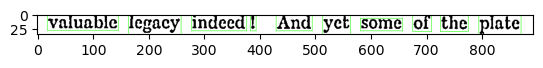

In [ ]:
word_list, thresh, image_with_boxes = segment_words(lines[7])

plt.imshow(image_with_boxes)
plt.show()

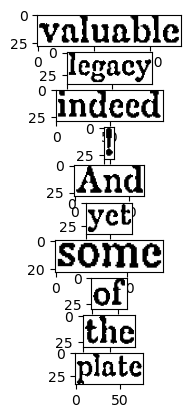

In [ ]:

plot_list(word_list)


In [204]:
# example_line = img_list[5]
def separateLetters(image):
    LINE_AREA_THRESHOLD = 1
    # LINE_GAUSSIAN_BLUR_KERNEL = (3, 3) # (height, width) - odd numbers
    LINE_DILATION_KERNEL_SIZE = (1, 1)  # (width, height)

    image_with_boxes = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # blur = cv2.GaussianBlur(gray, LINE_GAUSSIAN_BLUR_KERNEL, 0) # don't blur it again
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, LINE_DILATION_KERNEL_SIZE) # generates rectangular kernel of the given size
    dilate = cv2.dilate(thresh, kernel, iterations=1)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    word_list = []
    for c in cnts:
        area = cv2.contourArea(c)
        # maybe add an area threshold back in
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (36,255,12), 1) # wtf do these args mean
        ROI = image[y:y+h, x:x+w]
        word_list.append(ROI)
    
    return word_list, thresh

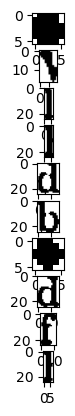

In [207]:
word_list, thresh = separateLetters(img_list(5))

plt.figure()
num_rows = len(word_list)

for i, word in enumerate(word_list):
    letters = separateLetters(word)
    for letter in letters:
        plt.subplot(num_rows, 1, i+1)
        plt.imshow(letter)
    
plt.show()